In [43]:
import xarray as xr
import dask
import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate
import matplotlib
import datetime
import pickle
import pandas as pd
import itertools
from scipy.stats import linregress
import seaborn as sns
sns.set('paper')
from scipy.stats import t
from statsmodels.tsa.stattools import acf

#import basemap
#fig sizes
Wf=(190/25.4)
Hf=(230/25.4)
Wf4=(95/25.4)
Hf4=(115/25.4)


This notebook examines the ignificance of trends in the fraction of extreems. In addition to using the effective sample size, we also use block bootstrapping to test for significance. 

In [44]:
# Plot timeseries of all the relevant variables

timeseries_vars = [
    'O2',
    'OmegaA',
    'T',
    # 'ALK_norm',
    # 'DIC_norm',
    # 'ALK',
    # 'DIC',
]


long_names = dict(
    O2=r"$\mathrm{O}_2$",
    OmegaA="$\Omega_A$",
    T="T"
    # ALK_norm="Normalized Alkalinity",
    # DIC_norm="Normalized DIC",
    # ALK="Alkalinity",
    # DIC="DIC",
)

units = dict(
    O2="mmol m$^{-3}$",
    OmegaA="(non-dimensional)",
    T="$^\circ$C",
    
    # ALK_norm="mmolk m$^{-3}$",
    # DIC_norm="mmolk m$^{-3}$",
    # ALK="mmolk m$^{-3}$",
    # DIC="mmolk m$^{-3}$"
)
color1='#00CD6C'#green
color2='#AF58BA'#purple
color3='#FFC61E' #yello
color4='#009ADE' #blue
color5='#F28522' #orange
color6='#A0B1BA' #gray
color7='#A6761D'#brown
color8='#FF1F5B' #red

In [45]:
def print_h(text, color_code):
    print(f"\033[{color_code}m{text}\033[0m")
print_h('text', 43)

text


To adjust for autocorrelation, we will use the method of Bretherton et al 1999. 

## Single stressor extremes in the Canyons

us the pickles created for the correlation analysis as they are not separated by upw/dwn. 

In [46]:
def get_Trends(X,Y):
     # 1. Perform linear regression
    XX=  np.array([x.astype('datetime64[s]').astype('int') for x in X])
    slope, intercept, r_value, p_value, std_err = linregress(XX, Y)
    #print('XX', XX)
    #print(slope)
    #print(p_value)
    # 2. Calculate residuals
    y_pred = intercept + slope * XX
    residuals = Y - y_pred
    
    # 3. Calculate lag-1 autocorrelation of residuals
    r1 = np.corrcoef(residuals[:-1], residuals[1:])[0, 1]
    #print('r1',r1)
    # 4. Calculate effective sample size
    Nt = len(Y)
    Ne = Nt * (1 - r1) / (1 + r1)
    print('Nt', Nt,'Ne',Ne)
 
    # 5. Adjust standard error of the slope
    adjusted_std_err = std_err * np.sqrt(Nt / Ne)
    
    # Output results
    print(f"Slope (units/year): {3600.*24*365*slope}")
   # print(f"Original Standard Error: {std_err}")
    #print(f"Adjusted Standard Error: {adjusted_std_err}")
    print(f"Original p-value: {p_value}")
    
    # You can also recalculate the t-statistic and p-value using the adjusted standard error:
    
    # Calculate the t-statistic
    t_stat = slope / adjusted_std_err
    
    # Calculate the p-value based on the adjusted effective sample size (Ne)
    adjusted_p_value = 2. * (1 - t.cdf(np.abs(t_stat), df=Ne-2))
    print(f"adjusted p-value: {adjusted_p_value}")  
    
    alpha = 0.05 #confidence interval
    t_critical = t.ppf(1 - alpha/2, df=Ne - 2)

    # Compute confidence intervals based on the adjusted standard errors
    slope_ci = (3600.*24*365*(slope - t_critical * adjusted_std_err), 3600.*24*365*(slope + t_critical * adjusted_std_err))
    intercept_ci = (3600.*24*365*(intercept - t_critical * adjusted_std_err), 3600.*24*365*(intercept + t_critical * adjusted_std_err))
    return 3600.*24*365*slope, adjusted_p_value, slope_ci

In [47]:
def davis_effective_sample_size(x, y, lags=None):
    """
    Calculate the effective sample size (Ne) based on the Davis (1976) formulation.
    
    Parameters:
    ----------
    x, y : array-like
        Input time series for correlation analysis.
    lags : int or None, optional
        The number of lags to consider. If None, will use all lags up to the maximum lag.
    
    Returns:
    -------
    Ne : float
        The effective sample size based on Davis (1976) formulation.
    """
    # Ensure the series are numpy arrays
    x = np.asarray(x)
    y = np.asarray(y)

    # Compute autocorrelations for x and y
    acf_x = acf(x, nlags=lags, fft=False)
    acf_y = acf(y, nlags=lags, fft=False)

    # Exclude the autocorrelation at lag 0 (it is always 1)
    acf_x_lags = acf_x[1:]
    acf_y_lags = acf_y[1:]

    # Compute the sum of the product of autocorrelations at each lag
    sum_acf_product = np.sum(acf_x_lags * acf_y_lags)

    # Calculate the effective sample size (Ne) based on the Davis formula
    N = len(x)
    Ne = N / (1 + sum_acf_product)

    return Ne
def get_Trends(X, Y):
    # 1. Perform linear regression
    XX = np.array([x.astype('datetime64[s]').astype('int') for x in X])  # Convert datetime to integer format
    slope, intercept, r_value, p_value, std_err = linregress(XX, Y)
    
    # 2. Calculate residuals
    y_pred = intercept + slope * XX
    residuals = Y - y_pred
    Nt=len(XX)
    # 3. Calculate autocorrelation at all lags
    Ne=davis_effective_sample_size(XX, Y, lags=None)
    print('Nt', Nt, 'Ne', Ne)
    
    # 6. Adjust standard error of the slope
    adjusted_std_err = std_err * np.sqrt(Nt / Ne)
    
    # Output results
    print(f"Slope (units/year): {3600.*24*365*slope}")
    print(f"Original p-value: {p_value}")
    
    # Recalculate the t-statistic and p-value using the adjusted standard error:
    t_stat = slope / adjusted_std_err
    adjusted_p_value = 2. * (1 - t.cdf(np.abs(t_stat), df=Ne - 2))
    print(f"Adjusted p-value: {adjusted_p_value}")  
    
    # Confidence intervals
    alpha = 0.05  # confidence interval
    t_critical = t.ppf(1 - alpha / 2, df=Ne - 2)

    # Compute confidence intervals based on the adjusted standard errors
    slope_ci = (3600. * 24 * 365 * (slope - t_critical * adjusted_std_err), 
                3600. * 24 * 365 * (slope + t_critical * adjusted_std_err))
    
    intercept_ci = (3600. * 24 * 365 * (intercept - t_critical * adjusted_std_err), 
                    3600. * 24 * 365 * (intercept + t_critical * adjusted_std_err))
    
    return 3600. * 24 * 365 * slope, adjusted_p_value, slope_ci

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

def block_bootstrap_trend_with_visualization(values, dates, block_size=365, n_iterations=10000, ci_percentile=95):
    """
    Perform block bootstrapping to estimate trends, calculate a bootstrap-based p-value,
    visualize the results, and return the confidence interval of the bootstrap slopes.

    Parameters:
        values (np.ndarray): Array of daily data values.
        dates (np.ndarray): Array of dates corresponding to the values (in datetime64 format).
        block_size (int): Approximate size of blocks in days (default is 365 for yearly blocks).
        n_iterations (int): Number of bootstrap iterations.
        ci_percentile (float): Percentile for confidence interval (default is 95).

    Returns:
        original_slope (float): Slope calculated from the original data in units of years.
        bootstrap_slopes (list): List of slope values from bootstrap samples in units of years.
        bootstrap_p_value (float): Bootstrap-based p-value.
        ci_lower (float): Lower bound of the confidence interval.
        ci_upper (float): Upper bound of the confidence interval.
    """
    if len(values) != len(dates):
        raise ValueError("The values and dates arrays must have the same length.")
    
    # Convert dates to timestamps (seconds since the epoch)
    dates_timestamp = np.array([x.astype('datetime64[s]').astype('int') for x in dates])
    
    # Calculate the original slope (in units per second)
    x_original = np.arange(len(values))
    original_slope, _, _, _, _ = linregress(dates_timestamp, values)
    
    # Convert the original slope to years (seconds per year)
    seconds_per_year = 365.25 * 24 * 60 * 60  # accounting for leap years roughly
    original_slope_years = original_slope * seconds_per_year
    
    years = np.unique(dates.astype("datetime64[Y]"))
    bootstrap_slopes = []
    
    for _ in range(n_iterations):
        # Sampling years with replacement
        sampled_years = np.random.choice(years, size=len(years), replace=True)
        sampled_indices = np.isin(dates.astype("datetime64[Y]"), sampled_years)
        bootstrap_sample = values[sampled_indices]
        bootstrap_dates_timestamp = dates_timestamp[sampled_indices]
        
        slope, _, _, _, _ = linregress(bootstrap_dates_timestamp, bootstrap_sample)
        
        # Convert the bootstrap slope to years (seconds per year)
        bootstrap_slope_years = slope * seconds_per_year
        bootstrap_slopes.append(bootstrap_slope_years)
    
    # Calculate one-sided bootstrap p-value
    if original_slope_years > 0:
        # Positive slope: p-value is proportion of bootstrap slopes >= original slope
        bootstrap_p_value = np.mean(np.array(bootstrap_slopes) >= original_slope_years)
        extreme_slopes = np.array(bootstrap_slopes) >= original_slope_years
    else:
        # Negative slope: p-value is proportion of bootstrap slopes <= original slope
        bootstrap_p_value = np.mean(np.array(bootstrap_slopes) <= original_slope_years)
        extreme_slopes = np.array(bootstrap_slopes) <= original_slope_years
    
    # Calculate the confidence interval (e.g., 95% CI)
    ci_lower = np.percentile(bootstrap_slopes, (100 - ci_percentile) / 2)
    ci_upper = np.percentile(bootstrap_slopes, 100 - (100 - ci_percentile) / 2)
    
    # Visualization
    plt.figure(figsize=(5,4))
    
    # Histogram of bootstrap slopes
    plt.hist(bootstrap_slopes, bins=30, alpha=0.7, color='skyblue', label="Bootstrap Slopes")
    
    # Original slope as vertical line
    plt.axvline(original_slope_years, color='red', linestyle='--', linewidth=2, label=f"Original Slope = {original_slope_years:.5f} units/year")
    
    # Shading extreme regions
    plt.hist(np.array(bootstrap_slopes)[extreme_slopes], bins=30, alpha=0.4, color='orange', label="Extreme Slopes")
    
    # Confidence interval lines
    plt.axvline(ci_lower, color='green', linestyle='-.', linewidth=2, label=f"{ci_percentile}% CI Lower = {ci_lower:.5f} units/year")
    plt.axvline(ci_upper, color='green', linestyle='-.', linewidth=2, label=f"{ci_percentile}% CI Upper = {ci_upper:.5f} units/year")
    
    # Labels and legend
    plt.title(f"Bootstrap Slope Distribution (p-value: {bootstrap_p_value:.5f})", fontsize=14)
    plt.xlabel("Slope (units/year)", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    print(ci_lower,ci_upper)
    return original_slope_years, bootstrap_slopes, bootstrap_p_value, ci_lower, ci_upper




In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

def moving_block_bootstrap_trend(values, dates, block_size=365, n_iterations=5000, ci_percentile=95):
    """
    Perform moving block bootstrapping to estimate trends, calculate a bootstrap-based p-value,
    and return the confidence interval of the bootstrap slopes.

    Parameters:
        values (np.ndarray): Array of data values (e.g., daily observations).
        dates (np.ndarray): Array of dates corresponding to the values (in datetime64 format).
        block_size (int): Length of each block in days (default is 365).
        n_iterations (int): Number of bootstrap iterations.
        ci_percentile (float): Percentile for confidence interval (default is 95).

    Returns:
        original_slope (float): Slope calculated from the original data in units of years.
        bootstrap_slopes (list): List of slope values from bootstrap samples in units of years.
        bootstrap_p_value (float): Bootstrap-based p-value.
        ci_lower (float): Lower bound of the confidence interval.
        ci_upper (float): Upper bound of the confidence interval.
    """
    if len(values) != len(dates):
        raise ValueError("The values and dates arrays must have the same length.")

    # Convert dates to timestamps (seconds since the epoch)
    dates_timestamp = np.array([x.astype('datetime64[s]').astype('int') for x in dates])

    # Calculate the original slope (in units per second)
    original_slope, _, _, _, _ = linregress(dates_timestamp, values)

    # Convert the original slope to years (seconds per year)
    seconds_per_year = 365.25 * 24 * 60 * 60  # accounting for leap years roughly
    original_slope_years = original_slope * seconds_per_year

    n = len(values)
    bootstrap_slopes = []

    for _ in range(n_iterations):
        # Generate bootstrap sample indices using moving blocks
        start_indices = np.random.randint(0, n - block_size + 1, size=n // block_size + 1)
        sampled_indices = []  # Initialize an empty list to accumulate indices
        for start in start_indices:
            block_indices = np.arange(start, start + block_size)  # Generate indices for the block
            sampled_indices.extend(block_indices)  # Append block indices to the list

        # Ensure sampled_indices has the correct length (truncate if too long)
        sampled_indices = np.array(sampled_indices[:n])

        # Create bootstrap sample
        bootstrap_sample = values[sampled_indices]
        bootstrap_dates_timestamp = dates_timestamp[sampled_indices]

        # Calculate slope for bootstrap sample
        slope, _, _, _, _ = linregress(bootstrap_dates_timestamp, bootstrap_sample)

        # Convert slope to years
        bootstrap_slope_years = slope * seconds_per_year
        bootstrap_slopes.append(bootstrap_slope_years)

    # Calculate one-sided bootstrap p-value
    if original_slope_years > 0:
        bootstrap_p_value = np.mean(np.array(bootstrap_slopes) >= original_slope_years)
    else:
        bootstrap_p_value = np.mean(np.array(bootstrap_slopes) <= original_slope_years)

    # Calculate confidence intervals
    ci_lower = np.percentile(bootstrap_slopes, (100 - ci_percentile) / 2)
    ci_upper = np.percentile(bootstrap_slopes, 100 - (100 - ci_percentile) / 2)

    # Visualization
    plt.figure(figsize=(5, 4))

    # Histogram of bootstrap slopes
    plt.hist(bootstrap_slopes, bins=30, alpha=0.7, color='skyblue', label="Bootstrap Slopes")

    # Original slope as vertical line
    plt.axvline(original_slope_years, color='red', linestyle='--', linewidth=2, label=f"Original Slope = {original_slope_years:.5f} units/year")

    # Confidence interval lines
    plt.axvline(ci_lower, color='green', linestyle='-.', linewidth=2, label=f"{ci_percentile}% CI Lower = {ci_lower:.5f} units/year")
    plt.axvline(ci_upper, color='green', linestyle='-.', linewidth=2, label=f"{ci_percentile}% CI Upper = {ci_upper:.5f} units/year")

    # Labels and legend
    plt.title(f"Moving Block Bootstrap Slope Distribution (p-value: {bootstrap_p_value:.5f})", fontsize=14)
    plt.xlabel("Slope (units/year)", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    return original_slope_years, bootstrap_slopes, bootstrap_p_value, ci_lower, ci_upper


In [50]:
# Example placeholders for clusters, variables, and data
clusters = [f"Cluster_{i}" for i in range(1, 7)]  # 6 clusters
variables = ['O2', 'T', 'OmegaA','OmegaA'+'T', 'OmegaA'+'O2', 'T'+'O2', 'T'+'O2'+'OmegaA' ]  # 7 variables

In [51]:
def get_results(cluster, results):
    
    for idx, var in enumerate(timeseries_vars):
        print(var)
        print('##################################')
        #ax = fig.add_subplot(3,1,idx+1)
        #fig, ax = plt.subplots(1,1, figsize = (Wf,Hf))
        for ii,label in enumerate(['Upwelling', 'Downwelling']):
            name0='pickles/'+label+'_'+cluster+'_'+var +'_corr.pickle'
            print(name0)
            with open(name0, 'rb') as fid:
                df = pickle.load(fid)
                df.name=var

            #print(df)
            #ax.scatter(df.time, df, label=label, s=2)
            if ii==0:
                upw=df
                
            else:
                dwn=df
        merged_da = xr.merge([dwn,upw])
        #print(merged_da, type(merged_da))
        X=merged_da.time.values
        Y=merged_da[var].values
        #slopes,p_values = block_bootstrap_trend_numpy(Y, X, n_iterations=1000)
        slope, bs_slopes,p_value, ci_lower,ci_upper = block_bootstrap_trend_with_visualization(
        Y, X, n_iterations=10000
    )
        #XX=np.array([x.astype('datetime64[s]').astype('int') for x in X])
        slope, p_val, CI=get_Trends(X,Y)
        print('Neff CI', CI[0], CI[1])
        if p_val<0.05:
            print(' The trend for var ', var, 'is significant according to Davis')
            print('slope', slope)
    
        slope, bootstrap_slopes, bootstrap_p_value, ci_lower_MBB, ci_upper_MBB=moving_block_bootstrap_trend(Y,X, block_size=365, n_iterations=5000, ci_percentile=95)
        #print('moving block',  bootstrap_p_value, ci_lower, ci_upper)
        if ci_lower*ci_upper>0:
            print(' The trend for  ', var, 'is significant according to moving bootstrapping')
        results.append({
                "Cluster": cluster,
                "Variable": var,
                "Slope": slope,
                "P-Value": p_value,
                "CI Lower": ci_lower,
                "CI Upper": ci_upper,
                "sig": ci_lower*ci_upper>0, 
                "P-MBB": bootstrap_p_value,
                "CI_low_MBB": ci_lower_MBB,
                "CI_upper_MBB": ci_upper_MBB,
                "sig_MBB": ci_lower_MBB*ci_upper_MBB>0})
    return results


The moving block and block bootstrapping m,ethods perform similarly. The Davis approach may not be appropriuate here as there is an assumption of stationarity. 

O2
##################################
pickles/Upwelling_5_O2_corr.pickle
pickles/Downwelling_5_O2_corr.pickle


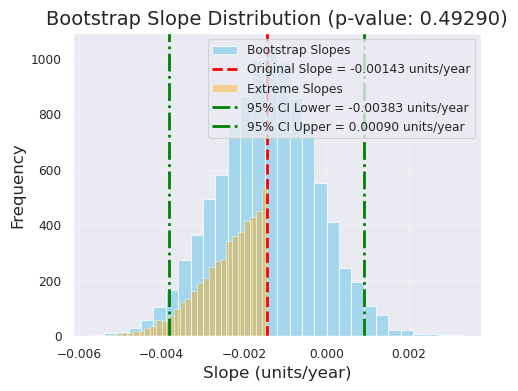

-0.003827001937367075 0.0008998087754383835
Nt 8766 Ne 294.63049447765826
Slope (units/year): -0.0014316150266053328
Original p-value: 2.3895037061821612e-11
Adjusted p-value: 0.22108970196433075
Neff CI -0.003729321400690179 0.0008660913474795134


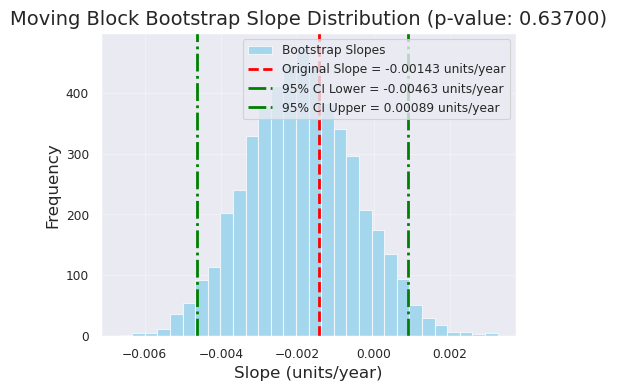

OmegaA
##################################
pickles/Upwelling_5_OmegaA_corr.pickle
pickles/Downwelling_5_OmegaA_corr.pickle


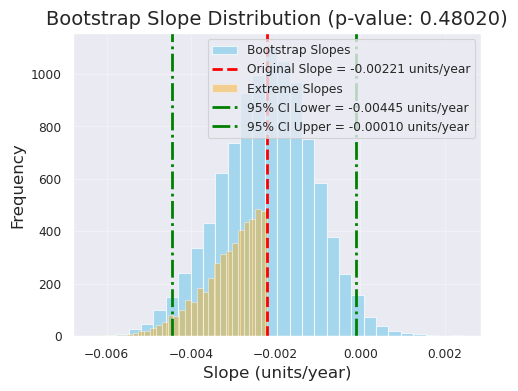

-0.004448860400932115 -9.735451668749826e-05
Nt 8766 Ne 290.4125589904878
Slope (units/year): -0.002207630851673623
Original p-value: 1.886401206499868e-24
Adjusted p-value: 0.06347628521917525
Neff CI -0.004539928539000109 0.00012466683565286315


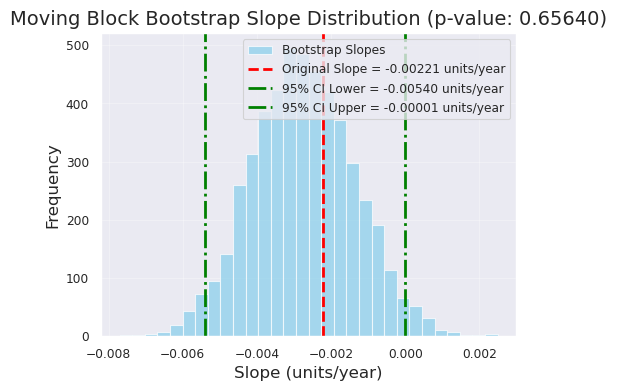

 The trend for   OmegaA is significant according to moving bootstrapping
T
##################################
pickles/Upwelling_5_T_corr.pickle
pickles/Downwelling_5_T_corr.pickle


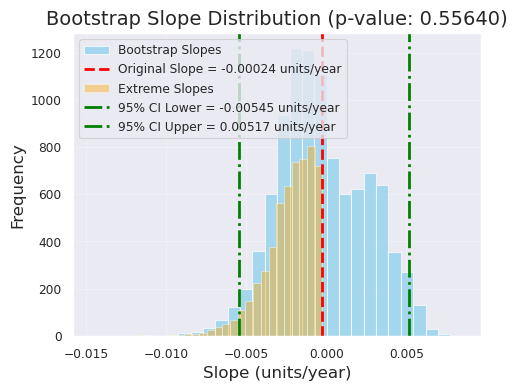

-0.0054474588172996365 0.005172603150890718
Nt 8766 Ne 294.7720500657125
Slope (units/year): -0.0002419343702601767
Original p-value: 0.31558855190027324
Adjusted p-value: 0.854109356970854
Neff CI -0.0028291468428626055 0.0023452781023422524


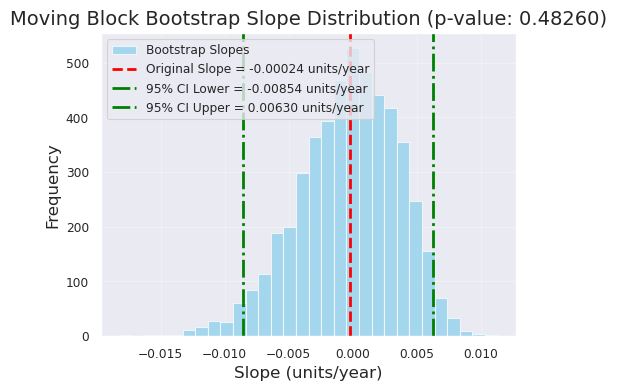

In [52]:
results=get_results('5', results)

O2
##################################
pickles/Upwelling_0_O2_corr.pickle
pickles/Downwelling_0_O2_corr.pickle


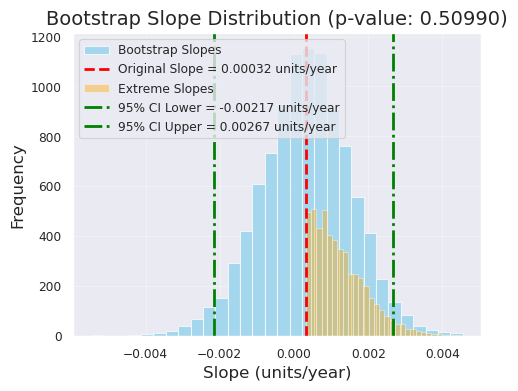

-0.002166549896571072 0.0026654452056815935
Nt 8766 Ne 293.704669390121
Slope (units/year): 0.00032180781245403056
Original p-value: 0.01780777386013846
Adjusted p-value: 0.6647394840715337
Neff CI -0.0011381498544378076 0.0017817654793458686


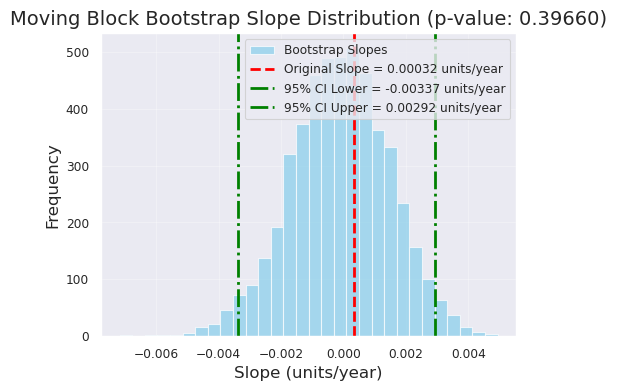

OmegaA
##################################
pickles/Upwelling_0_OmegaA_corr.pickle
pickles/Downwelling_0_OmegaA_corr.pickle


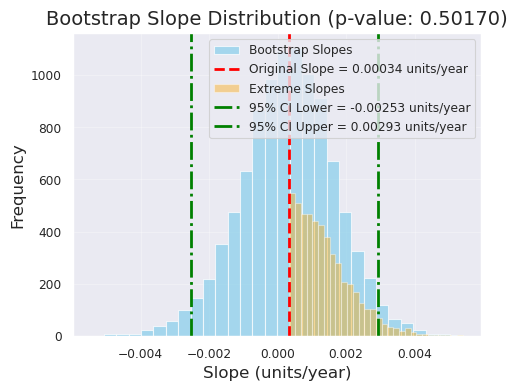

-0.002527521800351934 0.002932770873148563
Nt 8766 Ne 256.78421572459575
Slope (units/year): 0.00033679124093532846
Original p-value: 0.021434771123460428
Adjusted p-value: 0.6940859301685038
Neff CI -0.0013475989761951334 0.00202118145806579


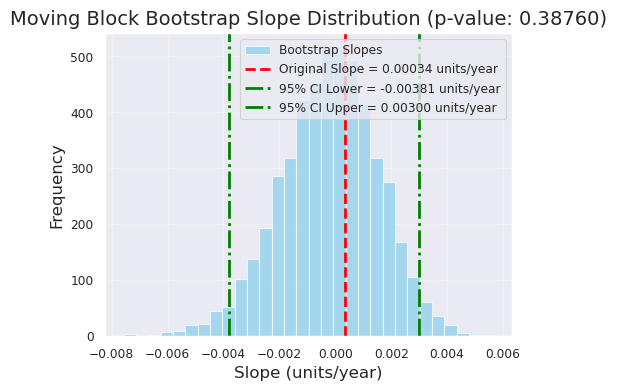

T
##################################
pickles/Upwelling_0_T_corr.pickle
pickles/Downwelling_0_T_corr.pickle


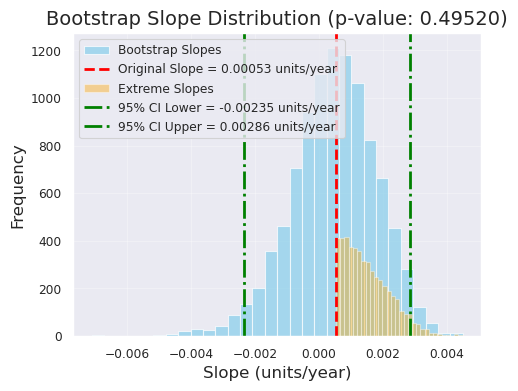

-0.002353083301970871 0.0028552669223079123
Nt 8766 Ne 335.5757482952309
Slope (units/year): 0.0005266834446465142
Original p-value: 0.007502558009307904
Adjusted p-value: 0.6011522542928334
Neff CI -0.001453350104426507 0.002506716993719535


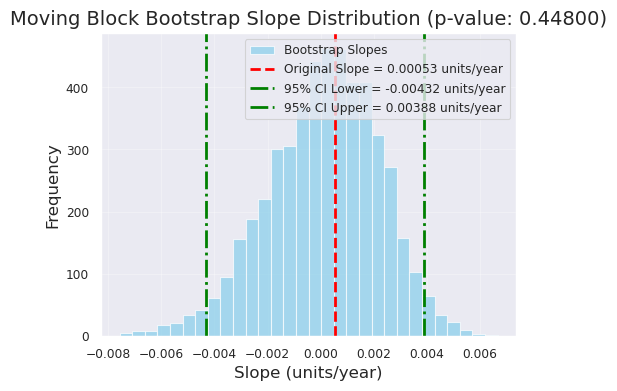

In [53]:
results=[]
results=get_results('0', results)

### Single stressor trends for the shallows

O2
##################################
pickles/Upwelling_3_O2_corr.pickle
pickles/Downwelling_3_O2_corr.pickle


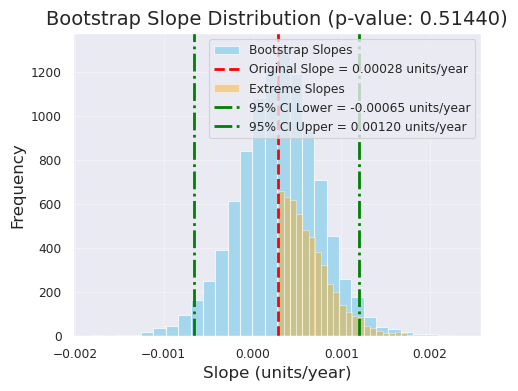

-0.0006539229973711827 0.0012013701853390896
Nt 8766 Ne 287.0224494821644
Slope (units/year): 0.0002846308946186279
Original p-value: 0.18448610192103476
Adjusted p-value: 0.8103857109158099
Neff CI -0.0020482550155067956 0.002617516804744051


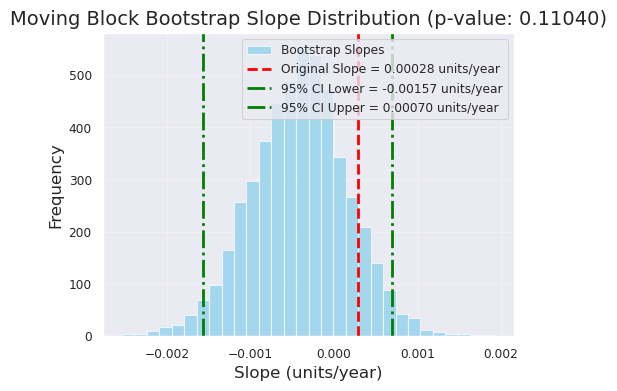

OmegaA
##################################
pickles/Upwelling_3_OmegaA_corr.pickle
pickles/Downwelling_3_OmegaA_corr.pickle


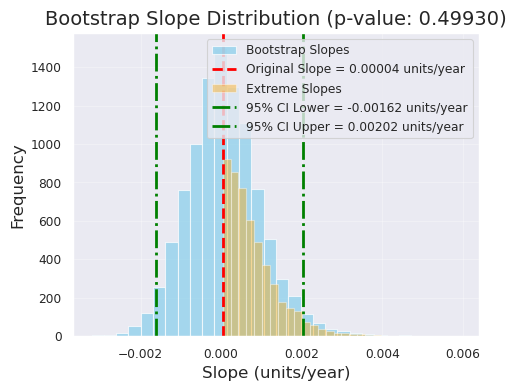

-0.0016219160435629685 0.0020228657985311652
Nt 8766 Ne 351.09568536769063
Slope (units/year): 3.5747476180162184e-05
Original p-value: 0.8200240000546327
Adjusted p-value: 0.9637079130451147
Neff CI -0.0015083275015549352 0.0015798224539152598


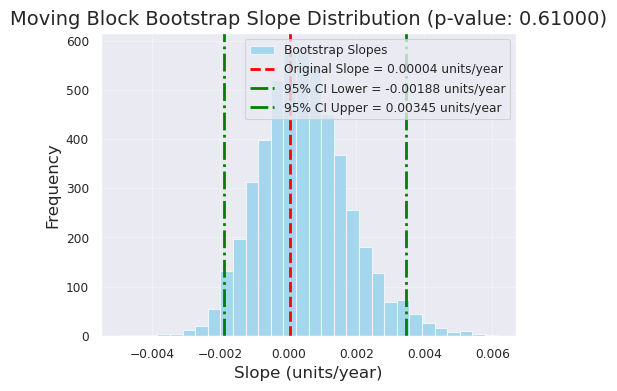

T
##################################
pickles/Upwelling_3_T_corr.pickle
pickles/Downwelling_3_T_corr.pickle


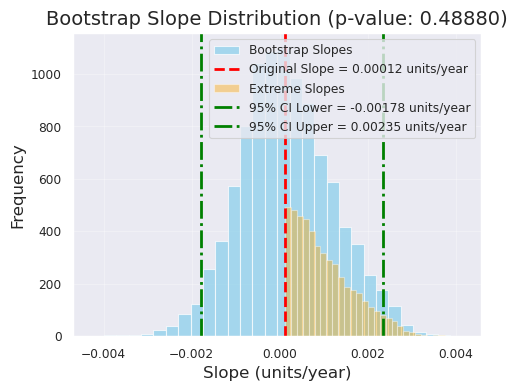

-0.0017772718890910033 0.0023460092685049397
Nt 8766 Ne 422.79111354370644
Slope (units/year): 0.00012024210692649265
Original p-value: 0.6802589055074588
Adjusted p-value: 0.9279261533094569
Neff CI -0.002491112951365456 0.002731597165218441


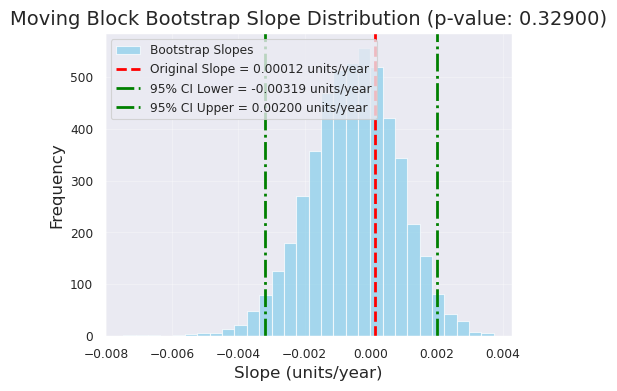

In [54]:
results=get_results('3', results)

O2
##################################
pickles/Upwelling_1_O2_corr.pickle
pickles/Downwelling_1_O2_corr.pickle


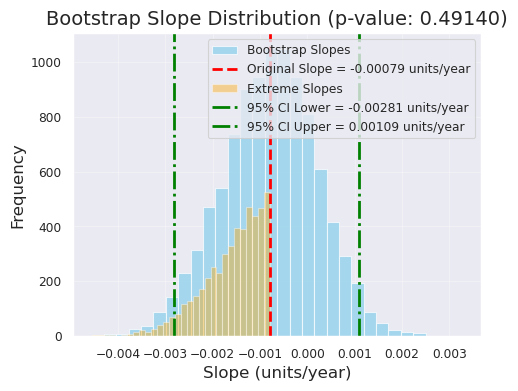

-0.0028130355100219545 0.0010938570627659738
Nt 8766 Ne 318.30108902981465
Slope (units/year): -0.000785757753556203
Original p-value: 0.0008542536113040157
Adjusted p-value: 0.5254710155104929
Neff CI -0.003217910408767244 0.0016463949016548383


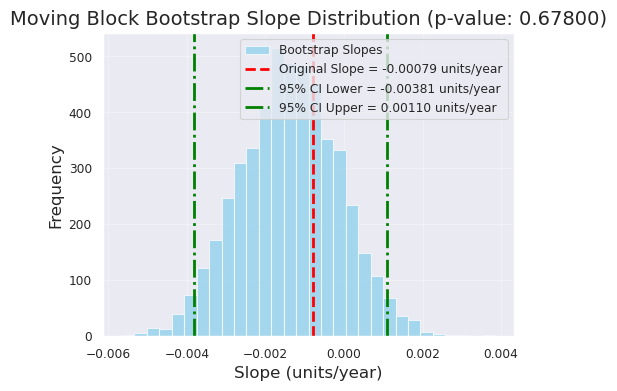

OmegaA
##################################
pickles/Upwelling_1_OmegaA_corr.pickle
pickles/Downwelling_1_OmegaA_corr.pickle


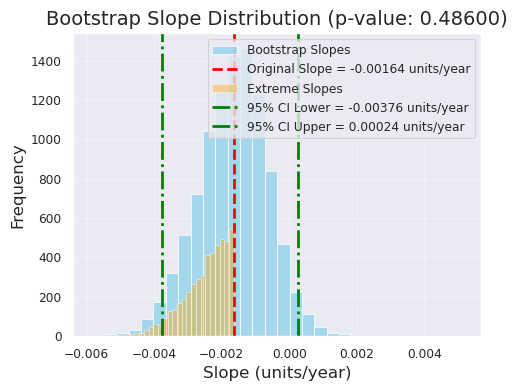

-0.0037619932643440527 0.00024364906025078982
Nt 8766 Ne 310.97835006852983
Slope (units/year): -0.0016381722016225644
Original p-value: 3.153723457387371e-13
Adjusted p-value: 0.17020535595130304
Neff CI -0.003982879631564429 0.0007065352283193006


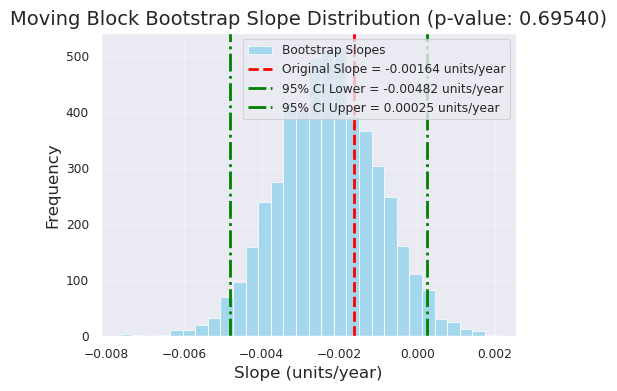

T
##################################
pickles/Upwelling_1_T_corr.pickle
pickles/Downwelling_1_T_corr.pickle


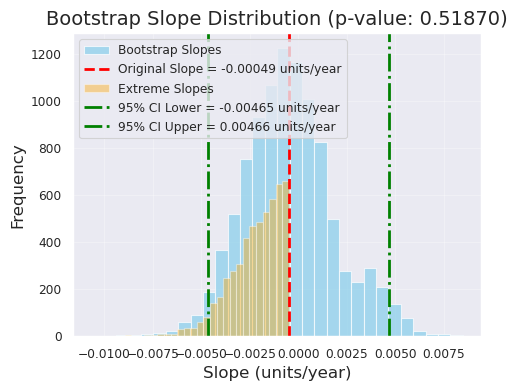

-0.00464793467613695 0.004655870082001095
Nt 8766 Ne 286.0488604410427
Slope (units/year): -0.0004885655730525782
Original p-value: 0.026965514492705723
Adjusted p-value: 0.6897140149170229
Neff CI -0.0028948367041296895 0.0019177055580245326


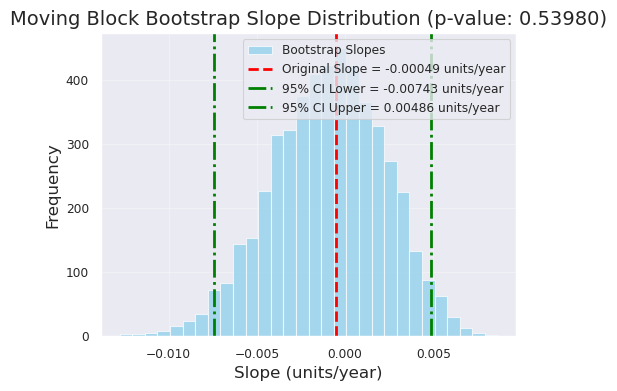

--------------- cluster 2 -------
O2
##################################
pickles/Upwelling_2_O2_corr.pickle
pickles/Downwelling_2_O2_corr.pickle


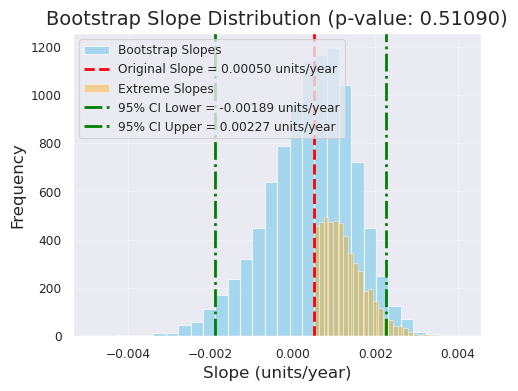

-0.0018923692746982842 0.0022685028837046923
Nt 8766 Ne 266.3770729572065
Slope (units/year): 0.000499748808938276
Original p-value: 8.327302437348197e-09
Adjusted p-value: 0.3156425684221149
Neff CI -0.0004789988233573073 0.0014784964412338593


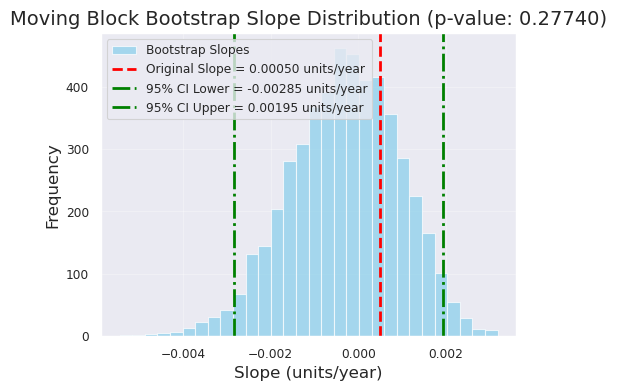

OmegaA
##################################
pickles/Upwelling_2_OmegaA_corr.pickle
pickles/Downwelling_2_OmegaA_corr.pickle


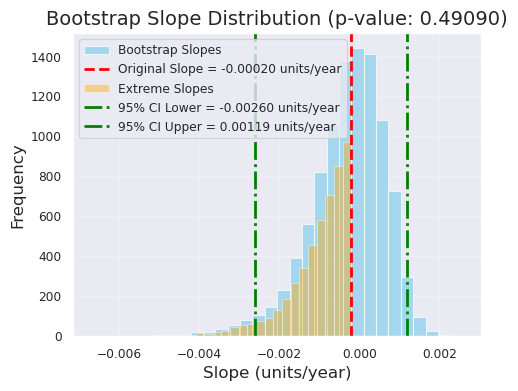

-0.002599399754972785 0.0011861111026821973
Nt 8766 Ne 289.70631229216923
Slope (units/year): -0.00019969149124273678
Original p-value: 0.04414256935015161
Adjusted p-value: 0.7146678244669813
Neff CI -0.0012737083675246105 0.0008743253850391368


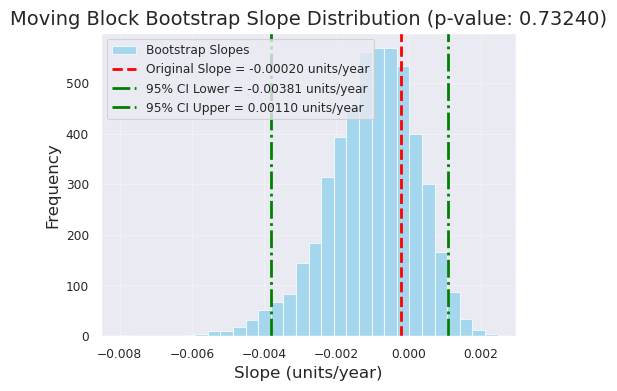

T
##################################
pickles/Upwelling_2_T_corr.pickle
pickles/Downwelling_2_T_corr.pickle


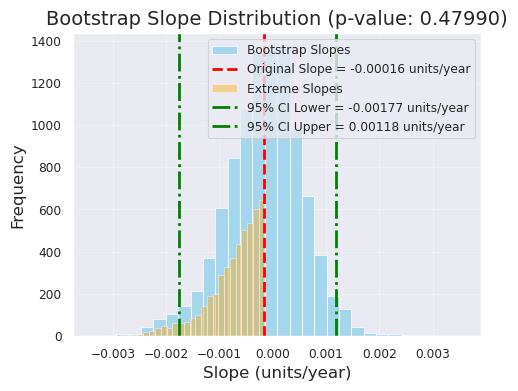

-0.0017675922604744037 0.001177603787177816
Nt 8766 Ne 309.3016473908783
Slope (units/year): -0.0001564374497457575
Original p-value: 0.14501411605899409
Adjusted p-value: 0.7844388969593272
Neff CI -0.0012807926754016589 0.0009679177759101439


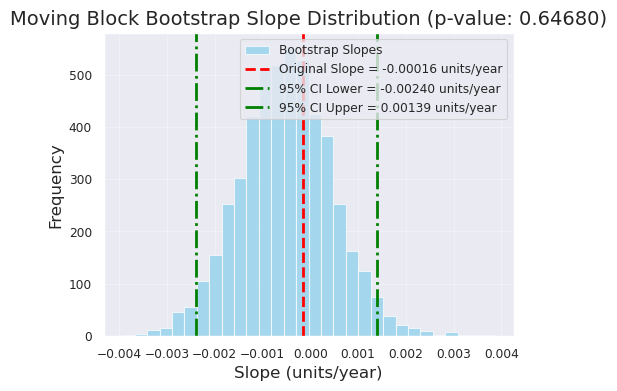

--------------- cluster 4 -------
O2
##################################
pickles/Upwelling_4_O2_corr.pickle
pickles/Downwelling_4_O2_corr.pickle


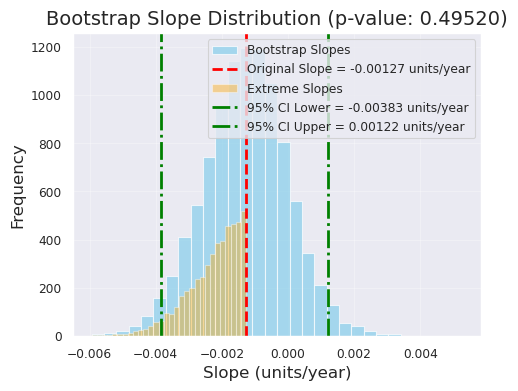

-0.0038338434108911254 0.0012154953570159069
Nt 8766 Ne 280.3444837030366
Slope (units/year): -0.001270744200873288
Original p-value: 6.668188776660266e-10
Adjusted p-value: 0.26998397574714805
Neff CI -0.0035339207259658416 0.0009924323242192657


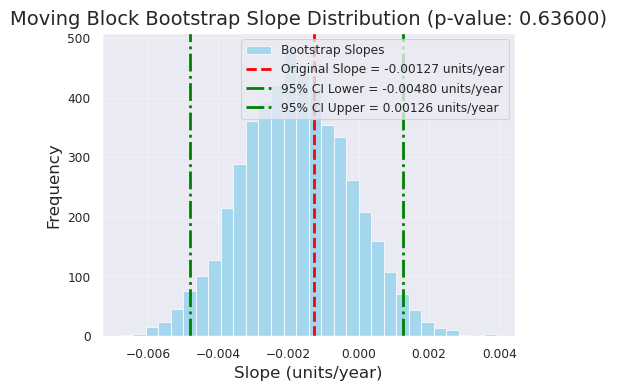

OmegaA
##################################
pickles/Upwelling_4_OmegaA_corr.pickle
pickles/Downwelling_4_OmegaA_corr.pickle


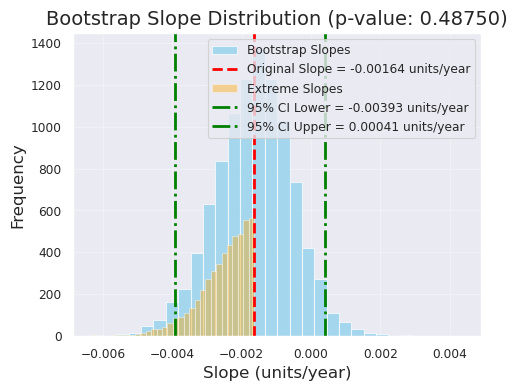

-0.003926894038343846 0.000410387897014235
Nt 8766 Ne 269.1181016451504
Slope (units/year): -0.0016376909649805048
Original p-value: 1.3365019887673798e-15
Adjusted p-value: 0.16184726366743463
Neff CI -0.00393630688534878 0.0006609249553877703


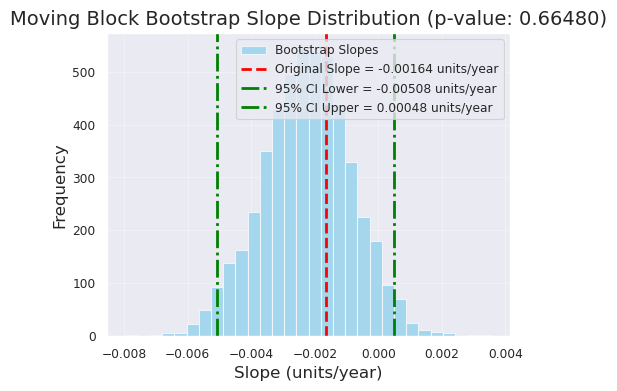

T
##################################
pickles/Upwelling_4_T_corr.pickle
pickles/Downwelling_4_T_corr.pickle


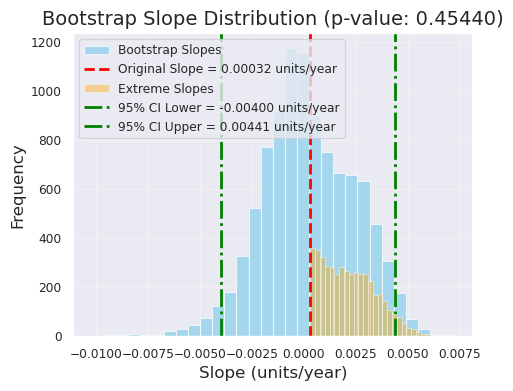

-0.003998126863350628 0.004414006647539318
Nt 8766 Ne 325.2535772456796
Slope (units/year): 0.00032246180995397196
Original p-value: 0.1999960089414944
Adjusted p-value: 0.8051590942162723
Neff CI -0.002247179319980937 0.0028921029398888813


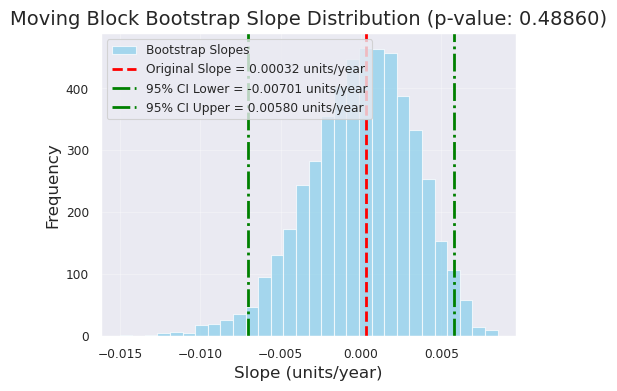

--------------- cluster 5 -------
O2
##################################
pickles/Upwelling_5_O2_corr.pickle
pickles/Downwelling_5_O2_corr.pickle


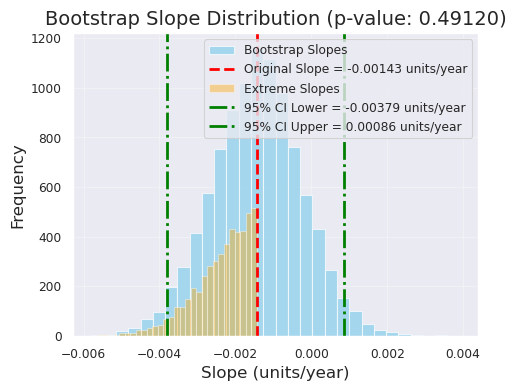

-0.0037899487647842386 0.0008635702030672252
Nt 8766 Ne 294.63049447765826
Slope (units/year): -0.0014316150266053328
Original p-value: 2.3895037061821612e-11
Adjusted p-value: 0.22108970196433075
Neff CI -0.003729321400690179 0.0008660913474795134


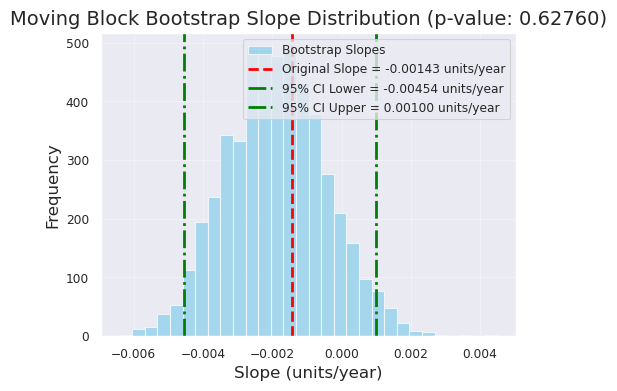

OmegaA
##################################
pickles/Upwelling_5_OmegaA_corr.pickle
pickles/Downwelling_5_OmegaA_corr.pickle


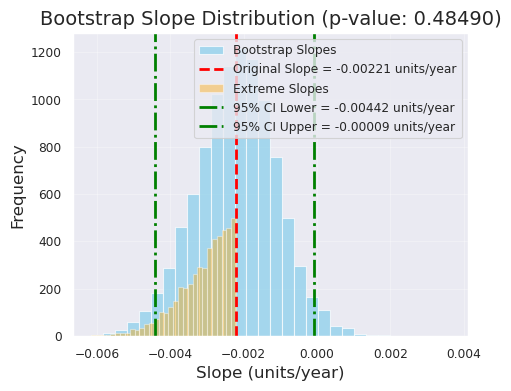

-0.004415125187925974 -8.712718694858233e-05
Nt 8766 Ne 290.4125589904878
Slope (units/year): -0.002207630851673623
Original p-value: 1.886401206499868e-24
Adjusted p-value: 0.06347628521917525
Neff CI -0.004539928539000109 0.00012466683565286315


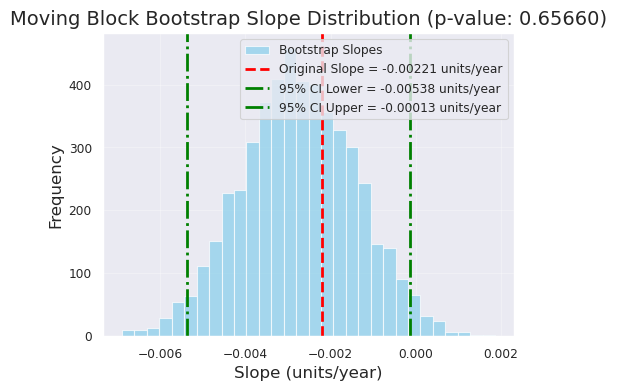

 The trend for   OmegaA is significant according to moving bootstrapping
T
##################################
pickles/Upwelling_5_T_corr.pickle
pickles/Downwelling_5_T_corr.pickle


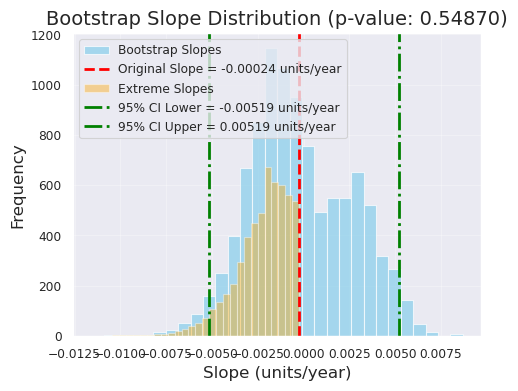

-0.005190893871414306 0.005188806476235266
Nt 8766 Ne 294.7720500657125
Slope (units/year): -0.0002419343702601767
Original p-value: 0.31558855190027324
Adjusted p-value: 0.854109356970854
Neff CI -0.0028291468428626055 0.0023452781023422524


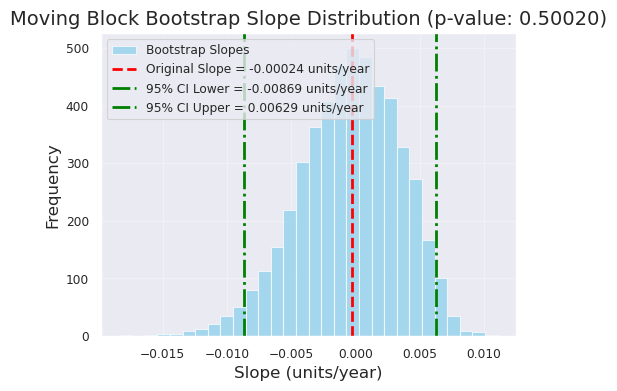

In [55]:
results=get_results('1', results)
print('--------------- cluster 2 -------')
results=get_results('2', results)
print('--------------- cluster 4 -------')

results=get_results('4', results)
print('--------------- cluster 5 -------')

results=get_results('5', results)
# Convert results to DataFrame for easier filtering and analysis
results_df = pd.DataFrame(results)

# Filter significant results
significant_results = results_df[results_df["sig"]]


In [56]:
results_df

,Cluster,Variable,Slope,P-Value,CI Lower,CI Upper,sig,P-MBB,CI_low_MBB,CI_upper_MBB,sig_MBB
0,0,O2,0.000322,0.5099,-0.002167,0.002665,False,0.3966,-0.003368,0.002924,False
1,0,OmegaA,0.000337,0.5017,-0.002528,0.002933,False,0.3876,-0.003812,0.002999,False
2,0,T,0.000527,0.4952,-0.002353,0.002855,False,0.4480,-0.004318,0.003883,False
3,3,O2,0.000285,0.5144,-0.000654,0.001201,False,0.1104,-0.001568,0.000697,False
4,3,OmegaA,0.000036,0.4993,-0.001622,0.002023,False,0.6100,-0.001882,0.003446,False
5,3,T,0.000120,0.4888,-0.001777,0.002346,False,0.3290,-0.003186,0.001997,False
6,1,O2,-0.000786,0.4914,-0.002813,0.001094,False,0.6780,-0.003809,0.001096,False
7,1,OmegaA,-0.001639,0.4860,-0.003762,0.000244,False,0.6954,-0.004818,0.000249,False
8,1,T,-0.000489,0.5187,-0.004648,0.004656,False,0.5398,-0.007433,0.004857,False
9,2,O2,0.000500,0.5109,-0.001892,0.002269,False,0.2774,-0.002849,0.001947,False


## Compound event trends for the canyons

In [57]:
def get_results_compound(cluster_id, results, dual):
    
    print(dual_extreme[dual][0]+dual_extreme[dual][1])
    print('##################################')
    #ax = fig.add_subplot(3,1,idx+1)
    #fig, ax = plt.subplots(1,1, figsize = (Wf,Hf))
    for ii,label in enumerate(['Upwelling', 'Downwelling']):
        var=dual_extreme[dual]
        name0='pickles/'+label+'_'+str(cluster_id)+'_'+dual_extreme[dual][0]+dual_extreme[dual][1]+'_corr.pickle'
        #name0=label+'_0'+var +'.pickle'
        with open(name0, 'rb') as fid:
            df = pickle.load(fid)
            df.name=var

        color=colors[ii]
        if ii==0:
            upw=df.to_dataset(name='var', promote_attrs=True)   
        else:
            dwn=df.to_dataset(name='var', promote_attrs=True) 
    merged_da = xr.merge([dwn,upw])
    #print(merged_da.time, merged_da)
    X=merged_da.time.values
    Y=merged_da['var'].values
    #slopes,p_values = block_bootstrap_trend_numpy(Y, X, n_iterations=1000)
    slope, bs_slopes,p_value, ci_lower,ci_upper = block_bootstrap_trend_with_visualization(
    Y, X, n_iterations=1000
)

    results.append({
            "Cluster": cluster_id,
            "Variable": dual_extreme[dual][0]+dual_extreme[dual][1],
            "Slope": slope,
            "P-Value": p_value,
            "CI Lower": ci_lower,
            "CI Upper": ci_upper,
            "sig": ci_lower*ci_upper>0})
    return results


There is an apparent linear trend in some of the triple extremes. Here, I test for significance. 



In [58]:
at=0.01
bt=0.95
colors=[color1, color2]
dual_extreme = list(itertools.combinations(timeseries_vars, 2))
dual_extreme += [('T','O2','OmegaA')]
labelnames = [r'$\mathrm{O}_2$ and $\Omega_A$', r'$\mathrm{O}_2$ and T', r'$\Omega_A$ and T',r'T and $\mathrm{O}_2$ and $\Omega_A$']
dual_extreme[0]

('O2', 'OmegaA')

O2OmegaA
##################################


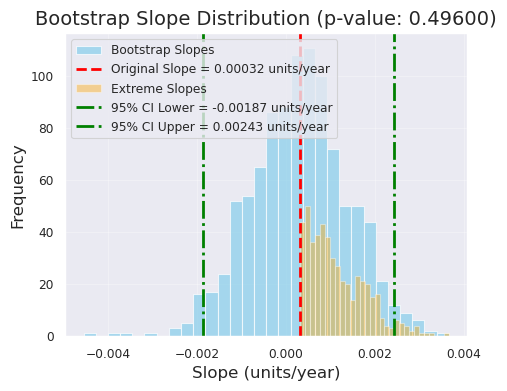

-0.0018742992369637907 0.0024304280837034904


In [59]:
results=get_results_compound(0, results,0)

In [60]:
results_df = pd.DataFrame(results)


In [61]:
results_df

,Cluster,Variable,Slope,P-Value,CI Lower,CI Upper,sig,P-MBB,CI_low_MBB,CI_upper_MBB,sig_MBB
0,0,O2,0.000322,0.5099,-0.002167,0.002665,False,0.3966,-0.003368,0.002924,False
1,0,OmegaA,0.000337,0.5017,-0.002528,0.002933,False,0.3876,-0.003812,0.002999,False
2,0,T,0.000527,0.4952,-0.002353,0.002855,False,0.4480,-0.004318,0.003883,False
3,3,O2,0.000285,0.5144,-0.000654,0.001201,False,0.1104,-0.001568,0.000697,False
4,3,OmegaA,0.000036,0.4993,-0.001622,0.002023,False,0.6100,-0.001882,0.003446,False
5,3,T,0.000120,0.4888,-0.001777,0.002346,False,0.3290,-0.003186,0.001997,False
6,1,O2,-0.000786,0.4914,-0.002813,0.001094,False,0.6780,-0.003809,0.001096,False
7,1,OmegaA,-0.001639,0.4860,-0.003762,0.000244,False,0.6954,-0.004818,0.000249,False
8,1,T,-0.000489,0.5187,-0.004648,0.004656,False,0.5398,-0.007433,0.004857,False
9,2,O2,0.000500,0.5109,-0.001892,0.002269,False,0.2774,-0.002849,0.001947,False


O2OmegaA
##################################


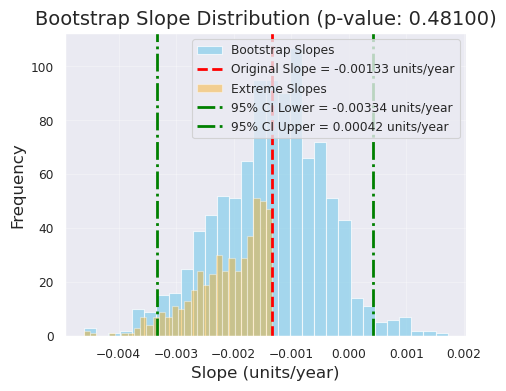

-0.0033418896458366626 0.0004171523305058167
O2OmegaA
##################################


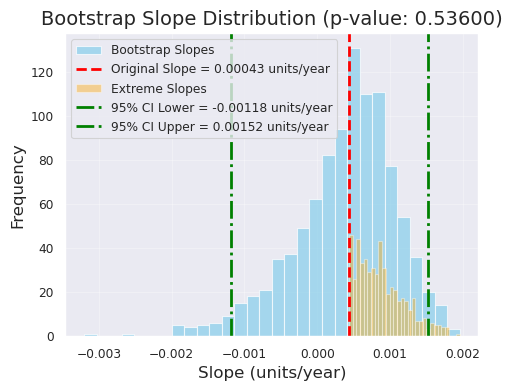

-0.001184680475124164 0.0015156966549321562
O2OmegaA
##################################


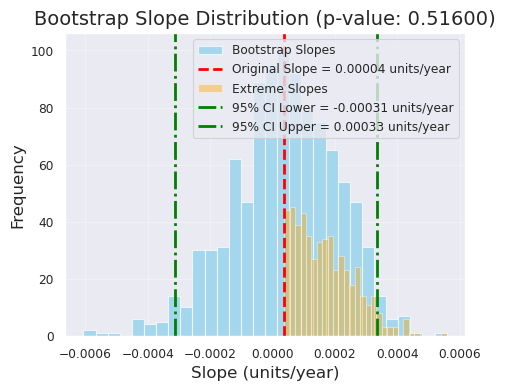

-0.00031370041017190315 0.000333227827192804
O2OmegaA
##################################


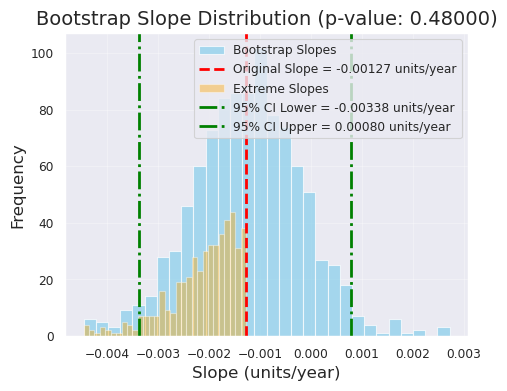

-0.003376290183840535 0.000798415218225915
O2OmegaA
##################################


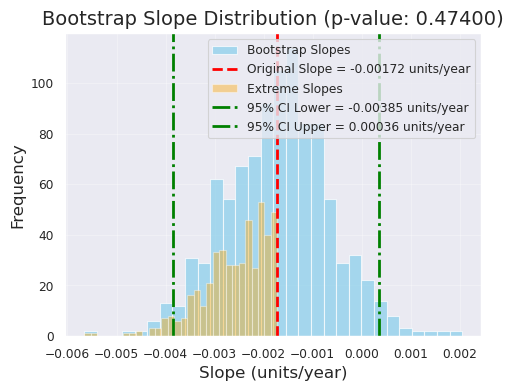

-0.0038499096705066306 0.00035868862304858654


In [62]:
for cluster_id in np.arange(1,6):
    results=get_results_compound(cluster_id, results, 0)

O2T
##################################


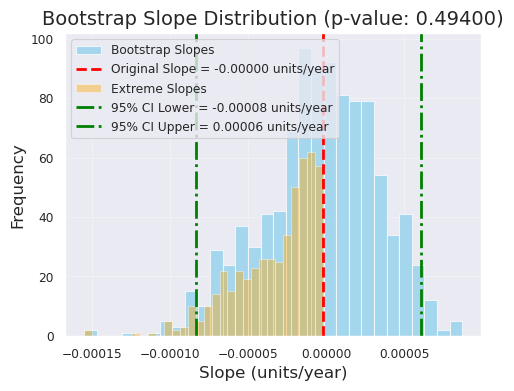

-8.358216887372109e-05 6.056666901927316e-05
O2T
##################################


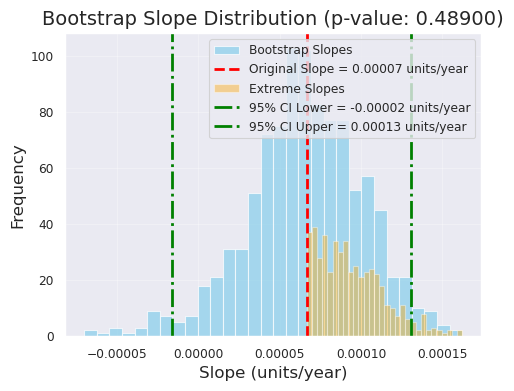

-1.5936906228647074e-05 0.0001308298923838112
O2T
##################################


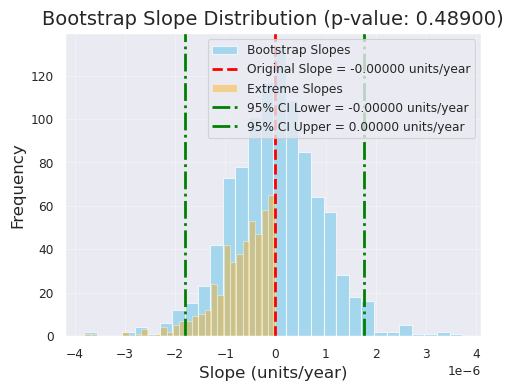

-1.8125319252085953e-06 1.7582641862877738e-06
O2T
##################################


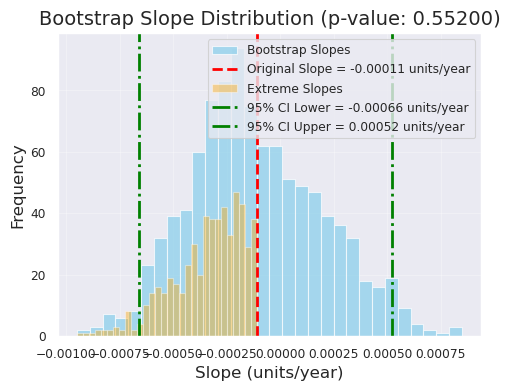

-0.0006581156665173003 0.0005242320544481373
O2T
##################################


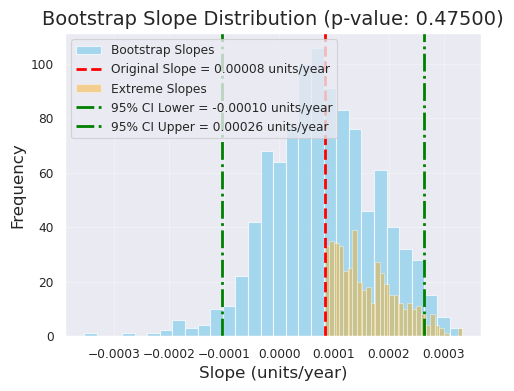

-0.00010433258694198601 0.00026484492452587727
O2T
##################################


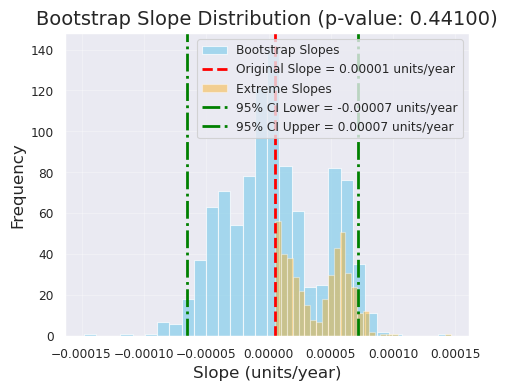

-6.579108439807843e-05 7.170900373532948e-05


In [63]:
for cluster_id in np.arange(0,6):
    results=get_results_compound(cluster_id, results, 1)

OmegaAT
##################################


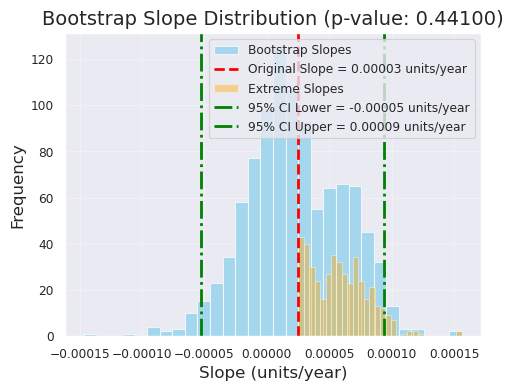

-5.2652926108648845e-05 9.414805811751757e-05
OmegaAT
##################################


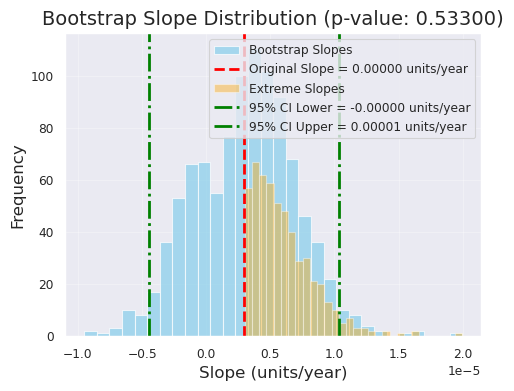

-4.503808631674513e-06 1.0351586365025382e-05
OmegaAT
##################################


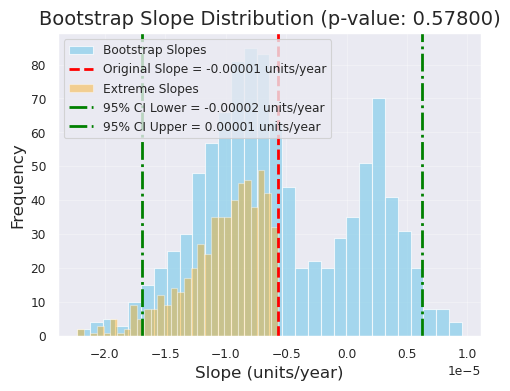

-1.6921401126082873e-05 6.2276978536272315e-06
OmegaAT
##################################


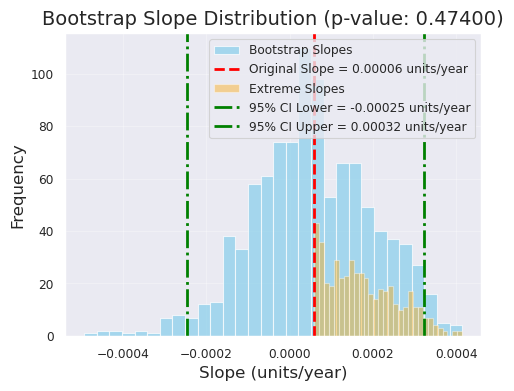

-0.00024573454680129077 0.000322015174062743
OmegaAT
##################################


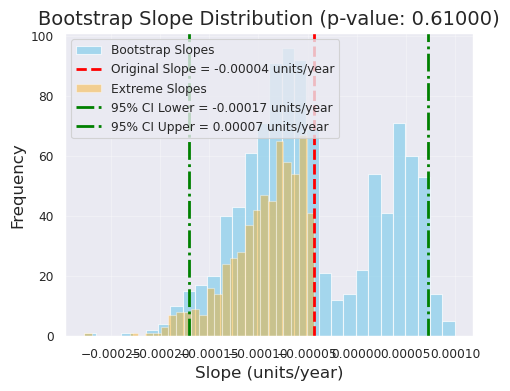

-0.00017050892515928188 7.224078294528009e-05


In [64]:
for cluster_id in np.arange(1,6):
    results=get_results_compound(cluster_id, results, 2)

TO2
##################################


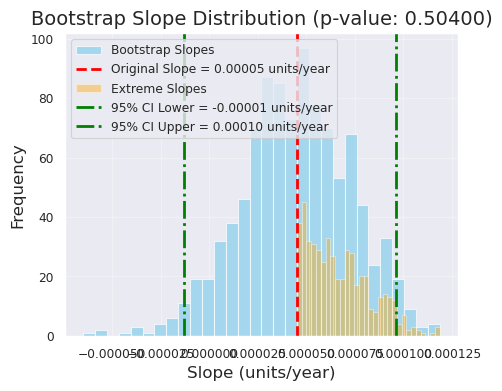

-1.2856235263727682e-05 9.62888237486307e-05
TO2
##################################


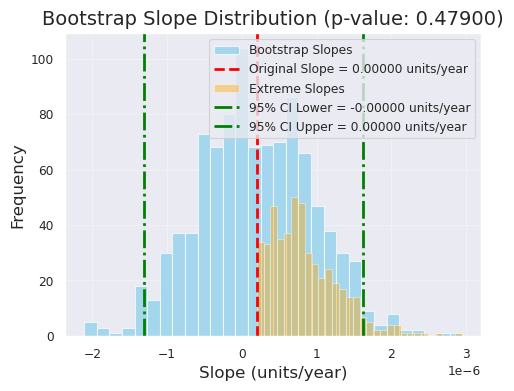

-1.3079513490263955e-06 1.6186408339102153e-06
TO2
##################################


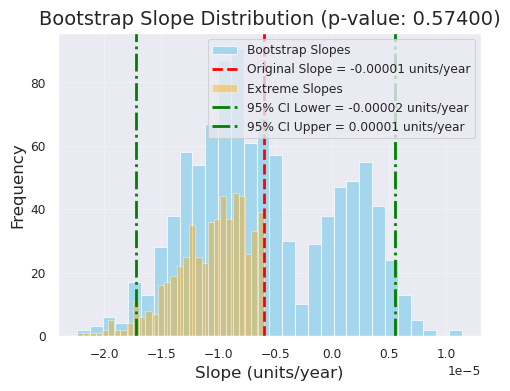

-1.7198309181799724e-05 5.509902111577402e-06
TO2
##################################


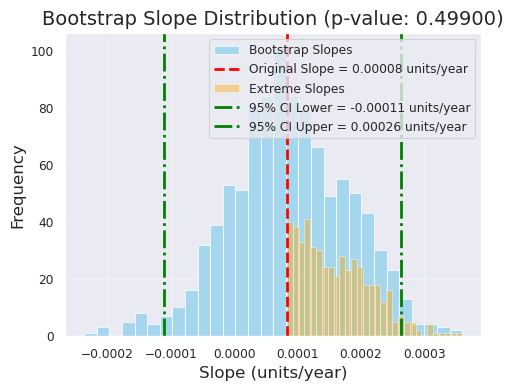

-0.0001101464542979832 0.00026391148609785075
TO2
##################################


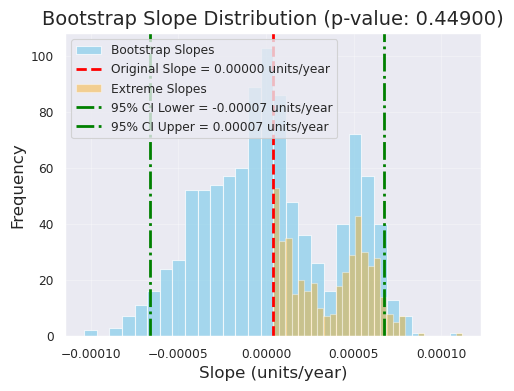

-6.606261930855625e-05 6.738925117294838e-05


In [65]:
for cluster_id in np.arange(1,6):
    results=get_results_compound(cluster_id, results, 3)

In [72]:
results_df = pd.DataFrame(results)


In [73]:
significant_results = results_df[results_df["sig"]]


In [84]:
significant_results

,Cluster,Variable,Slope,P-Value,CI Lower,CI Upper,sig,P-MBB,CI_low_MBB,CI_upper_MBB,sig_MBB
16,5,OmegaA,-0.002209,0.4849,-0.004415,-0.000087,True,0.6566,-0.00538,-0.000134,True


In [87]:
x=1/12
#fraction of extreme waters/ yr


0.08333333333333333

In [70]:
dual_extreme[2]

('OmegaA', 'T')

In [71]:
dual_extreme[3]

('T', 'O2', 'OmegaA')

The significance of the decreasing extremes in OmegA for cluster 5 do not depend on the number of bootstrapped samples.  